# Demo: Ensemble Transformer for Cross-Lingual Semantic Textual Similarity

This notebook demonstrates:
- Baseline cross-lingual STS using a single transformer model
- Ensemble-based STS using multiple multilingual transformers
- PCA-based dimensionality reduction analysis
- Evaluation using Pearson correlation
- Inference on new Persian–English sentence pairs

Dataset: PESTS (Fa-En)  
Paper: Ensemble Transformer for Cross-Lingual Semantic Textual Similarity



In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import paired_cosine_distances, cosine_similarity
from sklearn.decomposition import PCA
from scipy.stats import pearsonr


In [5]:
MODEL_NAMES = [
    "paraphrase-xlm-r-multilingual-v1",
    "paraphrase-multilingual-mpnet-base-v2",
    "paraphrase-multilingual-MiniLM-L12-v2"
]

print("Loading models...")
models = [SentenceTransformer(name) for name in MODEL_NAMES]
print("Models loaded.")


Loading models...


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: sentence-transformers/paraphrase-xlm-r-multilingual-v1
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

XLMRobertaModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-mpnet-base-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Models loaded.


In [6]:
# Dataset must be downloaded from:
# https://github.com/mohammadabdous/PESTS

DATA_PATH = "/content/FaEnDataSetV7.csv"

df = pd.read_csv(DATA_PATH)

df = df.dropna(subset=["farsiSentence", "englishSentence", "score"])
df["score"] = pd.to_numeric(df["score"], errors="coerce")
df = df.dropna(subset=["score"])

print("Dataset size:", len(df))
df.head()


Dataset size: 5367


,farsiSentence,englishSentence,score,Unnamed: 3,Unnamed: 4
0,آقای مک کورمک گفت هیچ توجیهی برای ارتکاب چنین ...,The Ghosi will face lifetime imprisonment if t...,0.0,NaN,NaN
1,امروز در بغداد، مشاور علمی صدام حسین خود را تس...,Pakistani Prime Minister Yousuf Raza Gilani me...,0.0,NaN,NaN
2,ایران داشتن هرگونه مسئولیت در این حمله را تکذی...,Mr. McCormack said there is no justification f...,0.0,NaN,NaN
3,اسیران یونیفورم به تن نداشتند و تائید هویت آنا...,"The United Nations says more than 1,400 of the...",0.0,NaN,NaN
4,تاکنون هیچ پیشرفتی درباره برطرف شدن این بن,Judge - Brian Hutton - says he is completely c...,0.0,NaN,NaN


In [7]:
baseline_model = models[0]
print("Encoding sentences with baseline model...")

emb_fa = baseline_model.encode(
    df["farsiSentence"].tolist(),
    show_progress_bar=True
)
emb_en = baseline_model.encode(
    df["englishSentence"].tolist(),
    show_progress_bar=True
)

baseline_sims = 1 - paired_cosine_distances(emb_fa, emb_en)
baseline_corr, _ = pearsonr(baseline_sims, df["score"])

print(f"Baseline Pearson Correlation: {baseline_corr:.4f}")


Encoding sentences with baseline model...


Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Baseline Pearson Correlation: 0.6552


In [8]:
def get_ensemble_embeddings(df, models):
    emb_fa_all = []
    emb_en_all = []

    for i, model in enumerate(models):
        print(f"Encoding with model {i+1}: {MODEL_NAMES[i]}")
        e_fa = model.encode(df["farsiSentence"].tolist(), show_progress_bar=True)
        e_en = model.encode(df["englishSentence"].tolist(), show_progress_bar=True)
        emb_fa_all.append(e_fa)
        emb_en_all.append(e_en)

    emb_fa_concat = np.concatenate(emb_fa_all, axis=1)
    emb_en_concat = np.concatenate(emb_en_all, axis=1)

    return emb_fa_concat, emb_en_concat


In [9]:
emb_fa_ens, emb_en_ens = get_ensemble_embeddings(df, models)

ensemble_sims = 1 - paired_cosine_distances(emb_fa_ens, emb_en_ens)
ensemble_corr, _ = pearsonr(ensemble_sims, df["score"])

print(f"Ensemble (No PCA) Pearson Correlation: {ensemble_corr:.4f}")


Encoding with model 1: paraphrase-xlm-r-multilingual-v1


Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Encoding with model 2: paraphrase-multilingual-mpnet-base-v2


Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Encoding with model 3: paraphrase-multilingual-MiniLM-L12-v2


Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Batches:   0%|          | 0/168 [00:00<?, ?it/s]

Ensemble (No PCA) Pearson Correlation: 0.6573


In [10]:
PCA_DIMS = [50, 100, 200, 300, 400]
pca_results = []

for dim in PCA_DIMS:
    pca = PCA(n_components=dim)
    fa_pca = pca.fit_transform(emb_fa_ens)
    en_pca = pca.transform(emb_en_ens)

    sims = 1 - paired_cosine_distances(fa_pca, en_pca)
    corr, _ = pearsonr(sims, df["score"])
    pca_results.append(corr)

    print(f"PCA {dim} dims → Pearson: {corr:.4f}")


PCA 50 dims → Pearson: 0.5954
PCA 100 dims → Pearson: 0.6400
PCA 200 dims → Pearson: 0.6611
PCA 300 dims → Pearson: 0.6655
PCA 400 dims → Pearson: 0.6664


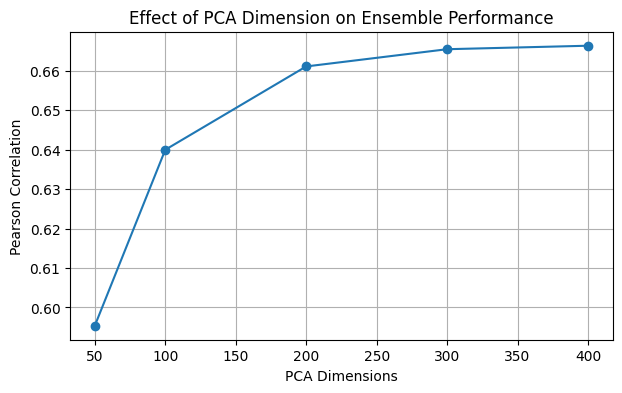

In [11]:
plt.figure(figsize=(7,4))
plt.plot(PCA_DIMS, pca_results, marker="o")
plt.xlabel("PCA Dimensions")
plt.ylabel("Pearson Correlation")
plt.title("Effect of PCA Dimension on Ensemble Performance")
plt.grid(True)
plt.show()


In [12]:
s1 = "این یک جمله آزمایشی است"
s2 = "This is a test sentence"

sims = []
for model in models:
    e1 = model.encode(s1, convert_to_numpy=True)
    e2 = model.encode(s2, convert_to_numpy=True)
    sims.append(cosine_similarity([e1], [e2])[0][0])

print("Individual similarities:", sims)
print("Ensemble similarity (average):", np.mean(sims))


Individual similarities: [np.float32(0.8713166), np.float32(0.8196258), np.float32(0.8376063)]
Ensemble similarity (average): 0.84284955
